In [1]:
from fastai import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.metrics import error_rate, accuracy
from torchvision.transforms import RandAugment
from torchvision.models.efficientnet import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import shutil
import hashlib
import os
import timm
import seaborn as sns
import cv2
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
base_path = Path("/kaggle/input")
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'
base_path.ls()

train_cleaned_path = Path('/kaggle/working/train_cleaned/')

if not train_cleaned_path.exists():
    print(f"Copying '{train_cleaned_path}'...")
    shutil.copytree(train_path, train_cleaned_path)
    print("Success")
else:
    print(f"'{train_cleaned_path}' already exist")

Copying '/kaggle/working/train_cleaned'...
Success


In [3]:
hashes = {}
duplicates_to_delete = [] # Kita akan simpan duplikat di sini

def file_hash(filepath):
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        while chunk := f.read(8192):
            hasher.update(chunk)
    return hasher.hexdigest()

for filepath in progress_bar(get_image_files(train_cleaned_path)):
    current_hash = file_hash(filepath)
    if current_hash in hashes:
        duplicates_to_delete.append(filepath.name) # Simpan nama filenya
    else:
        hashes[current_hash] = filepath

print(f"\nIdentifikasi selesai. Ditemukan {len(duplicates_to_delete)} file duplikat.")

set_of_duplicates = set(duplicates_to_delete)


Identifikasi selesai. Ditemukan 52 file duplikat.


In [4]:
move_map = {
    'balinese_train_000003.jpg': 'javanese',
    'balinese_train_000066.jpg': 'balinese',
    # 'balinese_train_000157.jpg': 'delete',
    'balinese_train_000278.jpg': 'javanese',
    # 'balinese_train_000559.jpg': 'delete',
    'balinese_train_000595.jpg': 'dayak',
    'balinese_train_000760.jpg': 'batak',
    'balinese_train_000762.jpg': 'batak',
    'balinese_train_000765.jpg': 'javanese',
    'balinese_train_000768.jpg': 'javanese',
    'balinese_train_000770.jpg': 'javanese',
    'balinese_train_000771.jpg': 'minangkabau',
    'balinese_train_000772.jpg': 'minangkabau',
    'balinese_train_000773.jpg': 'minangkabau',
    'balinese_train_000774.jpg': 'minangkabau',
    'balinese_train_000776.jpg': 'minangkabau',
    
    'batak_train_000001.jpg': 'balinese',
    'batak_train_000023.jpg': 'minangkabau',
    # 'batak_train_000057.jpg': 'delete',
    'batak_train_000059.jpg': 'minangkabau',
    'batak_train_000066.jpg': 'minangkabau',
    'batak_train_000086.jpg': 'balinese',
    'batak_train_000094.jpg': 'minangkabau',
    'batak_train_000095.jpg': 'minangkabau',
    
    'dayak_train_000004.jpg': 'minangkabau',
    'dayak_train_000019.jpg': 'balinese',
    'dayak_train_000026.jpg': 'minangkabau',
    'dayak_train_000052.jpg': 'balinese',
    
    'javanese_train_000007.jpg': 'balinese',
    'javanese_train_000009.jpg': 'balinese',
    'javanese_train_000015.jpg': 'dayak',
    'javanese_train_000032.jpg': 'balinese',
    'javanese_train_000024.jpg': 'balinese',
    'javanese_train_000050.jpg': 'balinese',
    # 'javanese_train_000055.jpg': 'delete',
    'javanese_train_000077.jpg': 'balinese',
    'javanese_train_000122.jpg': 'balinese',
    'javanese_train_000111.jpg': 'batak',
    'javanese_train_000202.jpg': 'balinese',
    'javanese_train_000213.jpg': 'batak',
    'javanese_train_000245.jpg': 'minangkabau',
    'javanese_train_000249.jpg': 'minangkabau',
    
    'minangkabau_train_000003.jpg' : 'balinese',
    # 'minangkabau_train_000008.jpg': 'delete', 
    'minangkabau_train_000005.jpg': 'balinese',
    'minangkabau_train_000010.jpg': 'balinese',
    'minangkabau_train_000012.jpg': 'batak',
    'minangkabau_train_000015.jpg': 'dayak',
    'minangkabau_train_000017.jpg': 'javanese',
    'minangkabau_train_000021.jpg': 'javanese',
    'minangkabau_train_000038.jpg': 'balinese',
    'minangkabau_train_000066.jpg': 'balinese',
    'minangkabau_train_000071.jpg': 'javanese',
    'minangkabau_train_000074.jpg': 'javanese',
    # 'minangkabau_train_000114.jpg': 'delete',
    'minangkabau_train_000117.jpg': 'balinese',
    'minangkabau_train_000134.jpg': 'minangkabau',
    'minangkabau_train_000180.jpg': 'javanese',
    'minangkabau_train_000200.jpg': 'javanese',
    # 'minangkabau_train_000231.jpg': 'delete',
    'minangkabau_train_000299.jpg': 'balinese',
    'minangkabau_train_000388.jpg': 'balinese',
    'minangkabau_train_000411.jpg': 'batak',
    'minangkabau_train_000414.jpg': 'javanese',
    'minangkabau_train_000416.jpg': 'javanese',
    'minangkabau_train_000459.jpg': 'javanese'
}

moved_count = 0
deleted_count = 0

for filename, target_folder in move_map.items():
    if filename in set_of_duplicates:
        source_path = next(train_cleaned_path.rglob(filename), None)
        if source_path:
            source_path.unlink()
            print(f"Deleted (Wrong label & Duplicate): {filename}")
            deleted_count += 1
            set_of_duplicates.remove(filename)
    else:
        source_path = next(train_cleaned_path.rglob(filename), None)
        if source_path:
            destination_path = train_cleaned_path / target_folder / filename
            destination_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.move(str(source_path), str(destination_path))
            print(f"Moved (Wrong label): {filename} ke {target_folder}")
            moved_count += 1

for filename in set_of_duplicates:
    source_path = next(train_cleaned_path.rglob(filename), None)
    if source_path:
        source_path.unlink()
        print(f"Deleted (Duplicate): {filename}")
        deleted_count += 1

print(f"File moved: {moved_count}")
print(f"File deleted: {deleted_count}")

Moved (Wrong label): balinese_train_000003.jpg ke javanese
Moved (Wrong label): balinese_train_000066.jpg ke balinese
Moved (Wrong label): balinese_train_000278.jpg ke javanese
Moved (Wrong label): balinese_train_000595.jpg ke dayak
Moved (Wrong label): balinese_train_000760.jpg ke batak
Moved (Wrong label): balinese_train_000762.jpg ke batak
Moved (Wrong label): balinese_train_000765.jpg ke javanese
Moved (Wrong label): balinese_train_000768.jpg ke javanese
Moved (Wrong label): balinese_train_000770.jpg ke javanese
Moved (Wrong label): balinese_train_000771.jpg ke minangkabau
Moved (Wrong label): balinese_train_000772.jpg ke minangkabau
Moved (Wrong label): balinese_train_000773.jpg ke minangkabau
Moved (Wrong label): balinese_train_000774.jpg ke minangkabau
Moved (Wrong label): balinese_train_000776.jpg ke minangkabau
Moved (Wrong label): batak_train_000001.jpg ke balinese
Moved (Wrong label): batak_train_000023.jpg ke minangkabau
Moved (Wrong label): batak_train_000059.jpg ke minang

In [5]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

aug = A.Compose
([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.15,
        rotate_limit=25,
        p=0.8
    ),
    A.OneOf([
        A.OpticalDistortion(distort_limit=0.2, p=1.0),
        A.GridDistortion(p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.3),
    A.OneOf([
        A.RandomRain(brightness_coefficient=0.8, drop_width=1, blur_value=3, p=1.0),
        A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.5, p=1.0),
        A.RandomSunFlare(p=1.0)
    ], p=0.2),
    A.RandomBrightnessContrast(p=0.8),
    A.HueSaturationValue(
        hue_shift_limit=15,
        sat_shift_limit=25,
        val_shift_limit=15,
        p=0.5
    ),
    A.Solarize(p=0.1),
    A.OneOf([
        A.GaussianBlur(p=1.0),
        A.MotionBlur(p=1.0),
    ], p=0.2),
    A.GridDropout(ratio=0.5, p=0.3)
])

[HorizontalFlip(p=0.5),
 ShiftScaleRotate(p=0.8, shift_limit_x=(-0.1, 0.1), shift_limit_y=(-0.1, 0.1), scale_limit=(-0.15000000000000002, 0.1499999999999999), rotate_limit=(-25.0, 25.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
 OneOf([
   OpticalDistortion(p=1.0, border_mode=0, distort_limit=(-0.2, 0.2), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, mode='camera'),
   GridDistortion(p=1.0, border_mode=0, distort_limit=(-0.3, 0.3), fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, normalized=True, num_steps=5),
   ElasticTransform(p=1.0, alpha=1.0, approximate=False, border_mode=0, fill=0.0, fill_mask=0.0, interpolation=1, keypoint_remapping_method='mask', mask_interpolation=0, noise_distribution='gaussian', same_dxdy=False, sigma=50.0),
 ], p=0.3),
 OneOf([
   RandomRain(p=1.0, blur_value=3, brightness_coefficient=0.8, 

In [6]:
train_path = train_cleaned_path

In [7]:
dls_128 = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    bs = 32,
    item_tfms = RandomResizedCrop(128, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

dls_224 = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    bs = 32,
    item_tfms = RandomResizedCrop(224, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

dls_300 = ImageDataLoaders.from_folder(
    train_path,
    valid_pct = 0.2,
    seed = 42,
    bs = 32,
    item_tfms = RandomResizedCrop(300, min_scale=0.75),
    batch_tfms = AlbumentationsTransform(aug)
)

# model = timm.create_model('efficientnetv2_m.in21k_ft_in1k', pretrained=True)

learn = vision_learner(
    dls_128,
    'tf_efficientnetv2_m.in21k',
    metrics = F1Score(average='macro'),
    loss_func = LabelSmoothingCrossEntropy(),
    path = '/kaggle/working/'
).to_fp16()

model.safetensors:   0%|          | 0.00/325M [00:00<?, ?B/s]

In [8]:
test_files = get_image_files(test_path)
test_dl = dls_224.test_dl(test_files)

print("Classes:", dls_224.vocab)
print("Number of classes:", len(dls_224.vocab))
print("Number of training images:", len(dls_224.train_ds))
print("Number of validation images:", len(dls_224.valid_ds))

Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1360
Number of validation images: 340


learning rate optimal: (0.00831763744354248, 0.0012022644514217973, 0.0030199517495930195, 0.002511886414140463)


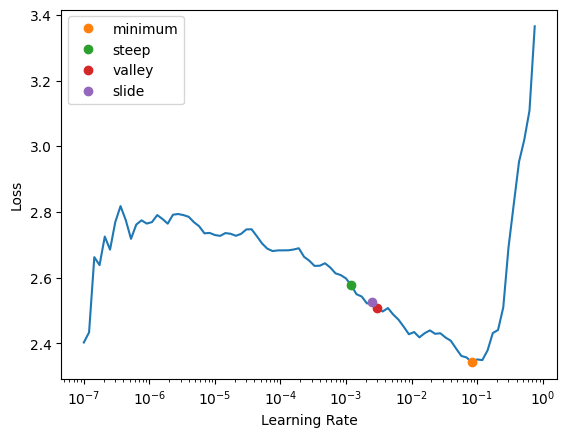

In [9]:
lrs_128 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'learning rate optimal: {lrs_128.minimum, lrs_128.steep, lrs_128.valley, lrs_128.slide}')

In [10]:
learn.fit_one_cycle(
    10, 
    lrs_128.valley,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,2.390432,1.343338,0.422994,02:36
1,2.115980,1.405100,0.418980,02:39
2,1.795617,1.152697,0.447342,02:37
3,1.495146,1.054938,0.514042,02:37
4,1.309876,0.983619,0.535357,02:38
5,1.176672,0.947297,0.587486,02:39
6,1.108719,0.929325,0.587753,02:38
7,1.078095,0.937560,0.597386,02:40
8,1.037845,0.936112,0.580847,02:42
9,1.015895,0.939363,0.598431,02:38


Better model found at epoch 0 with f1_score value: 0.4229935562468607.
Better model found at epoch 2 with f1_score value: 0.4473416496015896.
Better model found at epoch 3 with f1_score value: 0.5140418199979948.
Better model found at epoch 4 with f1_score value: 0.535356622845806.
Better model found at epoch 5 with f1_score value: 0.5874857201154778.
Better model found at epoch 6 with f1_score value: 0.587753167843789.
Better model found at epoch 7 with f1_score value: 0.5973858944146493.
Better model found at epoch 9 with f1_score value: 0.5984305641595216.


learning rate optimal: (0.001096478197723627, 1.3182567499825382e-06, 0.0014454397605732083, 0.002511886414140463)


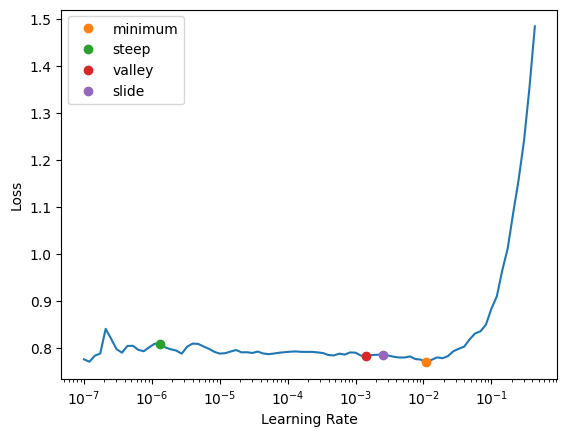

In [11]:
learn.dls = dls_224
lrs_224 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'learning rate optimal: {lrs_224.minimum, lrs_224.steep, lrs_224.valley, lrs_224.slide}')

In [12]:
learn.unfreeze()

learn.fit_one_cycle(
    40,
    lrs_224.minimum/10,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,1.028879,0.844477,0.630510,02:46
1,1.000700,0.836217,0.675660,02:43
2,0.982843,0.818751,0.690024,02:42
3,0.968049,0.803183,0.684806,02:45
4,0.940397,0.778255,0.706061,02:40
5,0.916827,0.754843,0.727675,02:45
6,0.884913,0.753164,0.745812,02:41
7,0.860671,0.738797,0.765732,02:44
8,0.843307,0.728750,0.735592,02:43
9,0.835315,0.730012,0.754177,02:43


Better model found at epoch 0 with f1_score value: 0.6305099863454914.
Better model found at epoch 1 with f1_score value: 0.6756602809706258.
Better model found at epoch 2 with f1_score value: 0.690024173295593.
Better model found at epoch 4 with f1_score value: 0.7060610798341063.
Better model found at epoch 5 with f1_score value: 0.7276752349364288.
Better model found at epoch 6 with f1_score value: 0.745811651164624.
Better model found at epoch 7 with f1_score value: 0.7657316218379128.
Better model found at epoch 10 with f1_score value: 0.7978591011675567.
Better model found at epoch 12 with f1_score value: 0.804920168698455.
Better model found at epoch 16 with f1_score value: 0.8053241886674298.
Better model found at epoch 24 with f1_score value: 0.816943355361291.


learning rate optimal: (0.00014454397605732084, 7.585775847473997e-07, 7.585775892948732e-05, 0.00019054606673307717)


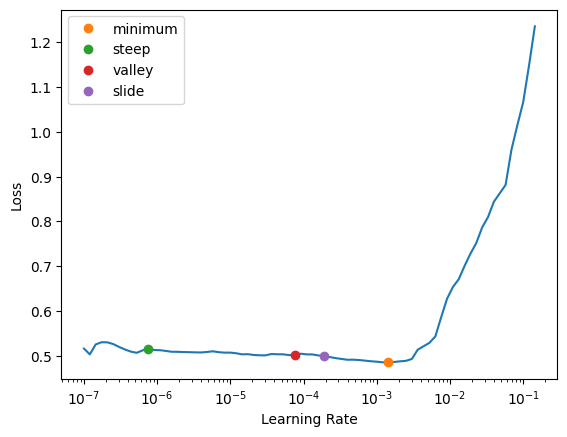

In [13]:
learn.dls = dls_300
lrs_300 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(f'learning rate optimal: {lrs_300.minimum, lrs_300.steep, lrs_300.valley, lrs_300.slide}')

In [14]:
learn.unfreeze()

learn.fit_one_cycle(
    20,
    lrs_300.minimum/10,
    cbs = [
        MixUp(0.6), 
        SaveModelCallback(monitor='f1_score')
    ]
)

epoch,train_loss,valid_loss,f1_score,time
0,0.774634,0.711793,0.793224,02:16
1,0.771589,0.704578,0.795471,02:13
2,0.769613,0.700943,0.814221,02:11
3,0.765151,0.699926,0.798541,02:11
4,0.755971,0.699113,0.834425,02:12
5,0.754327,0.703028,0.788371,02:12
6,0.758523,0.695474,0.791169,02:13
7,0.755701,0.692408,0.811379,02:11
8,0.750389,0.691016,0.791109,02:12
9,0.751499,0.696169,0.791904,02:10


Better model found at epoch 0 with f1_score value: 0.7932239482495558.
Better model found at epoch 1 with f1_score value: 0.7954705704596582.
Better model found at epoch 2 with f1_score value: 0.8142209567485166.
Better model found at epoch 4 with f1_score value: 0.8344251057357635.


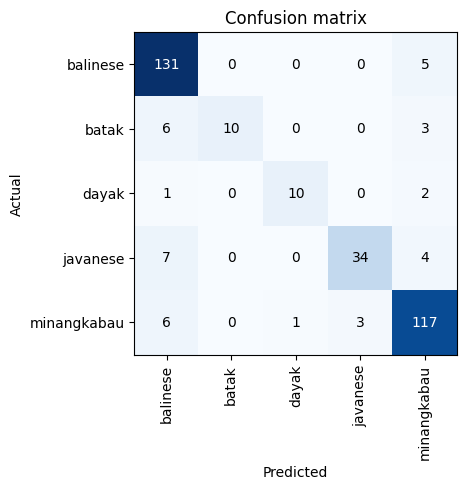

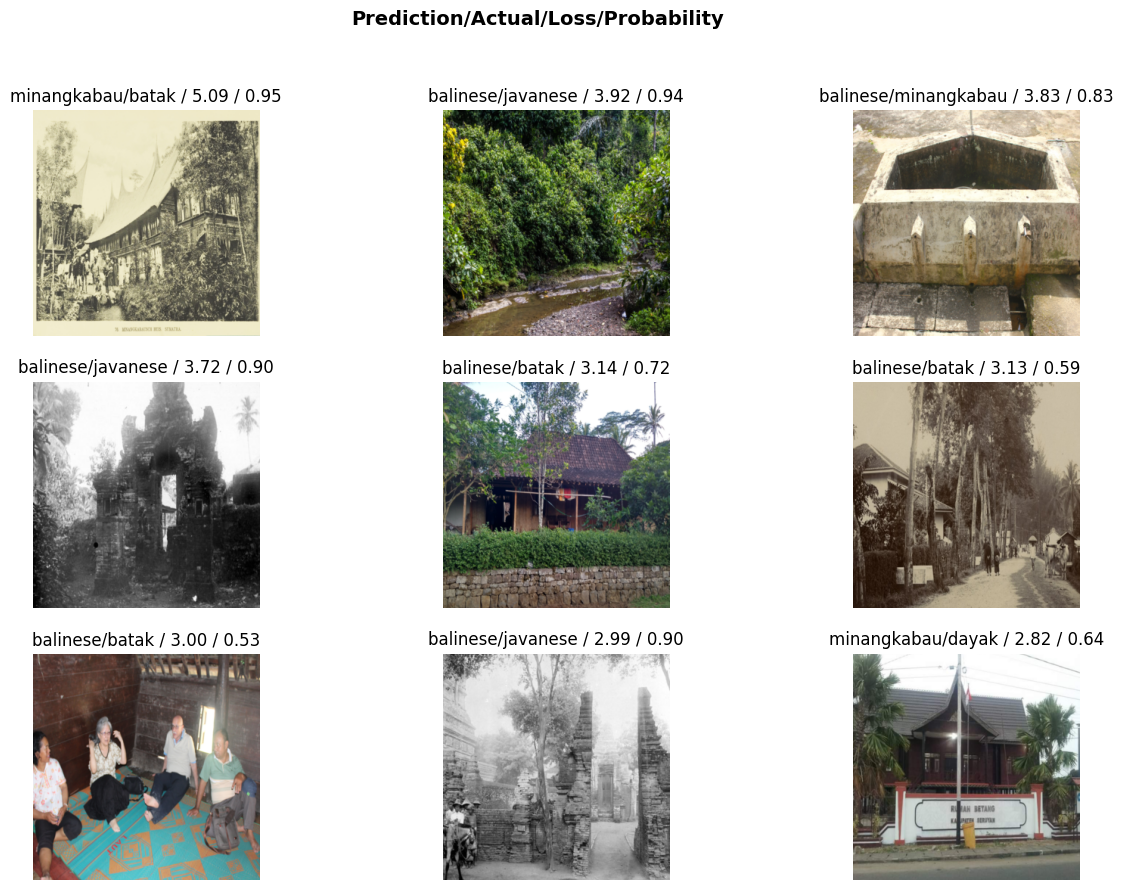

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,10))

In [16]:
interp.print_classification_report()

              precision    recall  f1-score   support

    balinese       0.87      0.96      0.91       136
       batak       1.00      0.53      0.69        19
       dayak       0.91      0.77      0.83        13
    javanese       0.92      0.76      0.83        45
 minangkabau       0.89      0.92      0.91       127

    accuracy                           0.89       340
   macro avg       0.92      0.79      0.83       340
weighted avg       0.89      0.89      0.88       340



In [17]:
nama_file_model = 'klasifikasi-rumah-adat-v1.pkl'
learn.export(nama_file_model)

print(f"Model berhasil disimpan sebagai '{nama_file_model}'!")

Model berhasil disimpan sebagai 'klasifikasi-rumah-adat-v1.pkl'!


In [18]:
test_files = get_image_files(test_path)
preds, _ = learn.get_preds(dl=dls_224.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls_224.vocab[i] for i in pred_labels]

In [19]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_get_preds = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_get_preds = submission_get_preds.set_index('id').loc[sample_sub['id']].reset_index()

submission_get_preds.sort_values('id', inplace = True)
submission_get_preds['style'].value_counts()

style
balinese       219
minangkabau    147
javanese        53
batak           17
dayak            8
Name: count, dtype: int64

In [20]:
# Save to CSV
submission_get_preds.to_csv('submission_get_preds.csv', index=False)
print("Submission file saved as submission_get_preds.csv")

Submission file saved as submission_get_preds.csv


In [21]:
test_dl = dls_224.test_dl(test_files)
preds, _ = learn.tta(dl=test_dl)
pred_labels = preds.argmax(dim=1)
label_names = [dls_224.vocab[i] for i in pred_labels]

In [22]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission_tta = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission_tta = submission_tta.set_index('id').loc[sample_sub['id']].reset_index()

submission_tta.sort_values('id', inplace = True)
submission_tta['style'].value_counts()

style
balinese       225
minangkabau    142
javanese        53
batak           16
dayak            8
Name: count, dtype: int64

In [23]:
# Save to CSV
submission_tta.to_csv('submission_tta.csv', index=False)
print("Submission file saved as submission_tta.csv")

Submission file saved as submission_tta.csv
